# k-means clustering for PtBi2

Import all the packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn import cluster
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap 

# These colors are chosen from color blind friendly palettes
color_blind_friendly_colors = [
    "#E69F00",  # orange
    "#B3DE69",  # light olive green
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
    "#1f77b4",  # teal
    "#8C564B",  # maroon
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#FF00FF",  # magenta
    "#999999",  # grey
]

color_blind_friendly_colors.append("#FFFFFF")  # White

# Change this if you want to have the data somewhere else. 

source_folder = 'data/'

# Energy and momentum axes - Note that this is called d27 but these are the same for all energies. 
file_path = source_folder + 'd27_E.txt' 
d27_E = np.genfromtxt(file_path, delimiter=',')
file_path = source_folder + 'd27_k.txt'
d27_k = np.genfromtxt(file_path, delimiter=',')

time = np.genfromtxt(source_folder + 'Data_t.txt', delimiter=',')


### Function to do the data treatment

This calculates the time traces of the intensity in a ROI. It gives $I(t)$ and $I_n(t)$. The latter is normalized to the maximum value.

In [2]:
def process_dataset(file_path, dimt, dimx, dimy, roi_k, roi_e):
    # Load and reshape data
    data = np.genfromtxt(file_path, delimiter=',').reshape(dimt, dimx, dimy)
    data = np.nan_to_num(data)  # Remove NaNs
    # prepare some abbreviations for the loop later
    # the two rois have the format (low boundary, high boundary, box size)
    num_rois_per_k = (roi_k[1] - roi_k[0]) // roi_k[2]
    num_rois_per_e = (roi_e[1] - roi_e[0]) // roi_e[2]
    n = roi_k[2]
    m = roi_e[2]
    # Calculate integrated intensities
    intensities = np.zeros((num_rois_per_k * num_rois_per_e, data.shape[0]))
    for idx, image in enumerate(data):
        roi_count = 0
        for roi_x in range(num_rois_per_k):
            for roi_y in range(num_rois_per_e):
                roi = image[(roi_x)*n + roi_k[0] :(roi_x+1)*n + roi_k[0], (roi_y)*m + roi_e[0] :(roi_y+1)*m + roi_e[0]]
                intensities[roi_count, idx] = np.sum(roi)
                roi_count += 1

    # Normalize the intensities such that the maximum (for each set of data run through this routine) is 100.
    max_intensity = np.max(intensities)
    intensities = (intensities / max_intensity) * 100

    # Normalize integrated intensities
    normalized_intensities = np.array([
        trace / np.max(trace) if np.max(trace) > 0 else trace / np.min(trace)
        for trace in intensities
    ])

    return intensities, normalized_intensities

Define the data sets

In [3]:
# This is structured as a dictionary of dictionaries, so that every energy gets a default k-range

datasets = {
    'd21': {
        'path': source_folder + 'Dyn_21p7eV_cinterp.txt',
        'def_roik': (100, 400, 10)
    },
    'd27': {
        'path': source_folder + 'Dyn_27p4eV_cinterp.txt',
        'def_roik': (50, 450, 10)
    },
    'd33': {
        'path': source_folder + 'Dyn_33p2eV_cinterp.txt',
        'def_roik': (50, 450, 10)
    }
}


Define dimensions of the data - always the same - and ROIs for various tests.

In [4]:
dimx, dimy, dimt = 500, 500, 27 # dimensions of the incoming data

roi_dict = {
    "roi_e10": (50, 150, 10),
    "roi_e20": (50, 150, 20),
    "roi_e30": (50, 150, 30),
    "roi_e40": (50, 150, 40),
    "roi_e150": (50, 150, 10),
    "roi_e200": (50, 200, 10),
    "roi_e250": (50, 250, 10),
    "roi_e350": (50, 350, 10),
    "roi_e450": (20, 420, 10)
}

# Define ROIs in time (for later)
roi_pre_t0 = ((0,6))
roi_t0 = ((7,23))
roi_late = ((24,27)) 

### Main code for clustering

This is the core code: It loads and processes all three data sets and then, for each data set, runs the k-means on the time traces for each  ROI and for each normalized  ROI. The number of clusters for k-means and the size of the ROIs can be varied for testing purposes. 

In [5]:
n_clusters = 5

results = {}  # This dictionary will store all results, keyed by the suffix ('20', '30', etc.)

# for suffix in ['20', '30', '150', '200', '250', '350', '450']:  # Extend this list based on the suffixes you have in roi_dict
for suffix in ['450']:  # Extend this list based on the suffixes you have in roi_dict
    # Dynamically access roi_k and roi_e values from roi_dict
    roi_e = roi_dict[f'roi_e{suffix}']
    
    current_results = {}
    
    for label, dataset_info in datasets.items():
        # Extract the file path from the dataset_info
        path = dataset_info['path']
        roi_k = dataset_info['def_roik']
        # Process each dataset
        intensities, norm_intensities = process_dataset(path, dimt, dimx, dimy, roi_k, roi_e)
        
        # K-means clustering on intensities
        kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities)

        # K-means clustering on normalized_intensities
        kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensities)

        # Store the results for this label
        current_results[label] = {
            'intensities': intensities,
            'normalized_intensities': norm_intensities,
            'kmeans_all': kmeans_intensities,
            'kmeans_norm': kmeans_norm_intensities
        }
    
    # After processing all labels for this suffix, store them in the main results dictionary
    results[f'results{suffix}'] = current_results


This creates a colour map that can be changed deliberately using the index_map. 


In [6]:
def create_custom_cmap(n_clusters, index_map, color_blind_friendly_colors):
    reordered_colors = [color_blind_friendly_colors[index_map[i]] for i in range(n_clusters)]
    return ListedColormap(reordered_colors)

The colour ordering is like this throughout the notebook. This should be used as a colour bar for all the graphs.

In [7]:
index_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters=10, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)

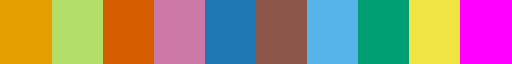

In [8]:
custom_cmap

## Figure 5 and Figure 6


### Code for plotting


Routines to plot the **raw** clusters and the traces.

In [9]:
def plot_clusters_raw(n_clusters, results, custom_cmap):
    interested_label = 'd27'
    interested_suffix = '450'
    roi_e = roi_dict[f'roi_e{interested_suffix}']
    num_rois_e = (roi_e[1] - roi_e[0]) // roi_e[2]
    specific_results = results[f'results{interested_suffix}'][interested_label]
    roi_k = datasets[interested_label]['def_roik']
    num_rois_k = (roi_k[1] - roi_k[0]) // roi_k[2]

    # Retrieve the KMeans models
    kmeans_intensities_model = specific_results['kmeans_all']
    cluster_labels_intensities = kmeans_intensities_model.labels_

    fig, ax = plt.subplots(figsize=(4, 8))   
    
    # Generate the cluster images using the remapped labels
    cluster_image_all = np.zeros((num_rois_k, num_rois_e))
    k = 0
    roi_y_values = np.zeros_like(cluster_labels_intensities, dtype=float)

    for roi_x in range(num_rois_k):
        for roi_y in range(num_rois_e):
            cluster_image_all[roi_x, roi_y] = cluster_labels_intensities[k]
            roi_y_values[k] = roi_y  # Store roi_y value corresponding to each label
            k += 1

    # Calculate average and standard deviation of roi_y for each cluster
    average_roi_y = np.zeros(n_clusters)
    std_dev_roi_y = np.zeros(n_clusters)
    average_e = np.zeros(n_clusters)
    std_dev_e = np.zeros(n_clusters)
    for i in range(n_clusters):
        indices = (cluster_labels_intensities == i)
        average_roi_y[i] = np.mean(roi_y_values[indices])
        average_e[i] = d27_E[roi_e[0]] + (d27_E[roi_e[1]] - d27_E[roi_e[0]]) * (0.5 + np.mean(roi_y_values[indices])) /num_rois_e
        std_dev_roi_y[i] = np.std(roi_y_values[indices])
        std_dev_e[i] = (d27_E[roi_e[1]] - d27_E[roi_e[0]]) * np.std(roi_y_values[indices]) / num_rois_e
        #print(f"Cluster {i}: Average roi_y = {average_roi_y[i]:.2f}, Std Dev = {std_dev_roi_y[i]:.2f}")
        print(f"Cluster {i}: Average energy = {average_e[i]:.2f}, Std Dev = {std_dev_e[i]:.2f}")


    # Plotting "All Intensities"
    im_all = ax.imshow(cluster_image_all.T, cmap=custom_cmap, extent=[d27_k[roi_k[0]], d27_k[roi_k[1]], d27_E[roi_e[1]], d27_E[roi_e[0]]])
    plt.colorbar(im_all, ax=ax, fraction=0.046, pad=0.04)
    ax.invert_yaxis()
    ax.set_xlabel(r"$\mathit{k}(\AA^{-1})$")
    ax.set_ylabel(r"$E-E_{\mathrm{F}}(\mathrm{eV)}$")
    # plt.savefig('clusters_raw.svg', format='svg')
    # plt.savefig('clusters_raw.pdf', format='pdf')
    fig.tight_layout()
    plt.show()



In [10]:


def plot_cluster_means_raw(n_clusters, results, custom_cmap):
    # Assuming other necessary parts of the function are defined elsewhere

    interested_label = 'd27'
    interested_suffix = '450'

    specific_results = results[f'results{interested_suffix}'][interested_label]
    kmeans_intensities_model = specific_results['kmeans_all']
    cluster_centers_intensities = kmeans_intensities_model.cluster_centers_
    labels = kmeans_intensities_model.labels_
    intensities = results[f'results{interested_suffix}'][interested_label]['intensities']
    # Calculate the standard deviation of data points in each cluster
    cluster_stds = []
    for i in range(n_clusters):
        cluster_points = intensities[labels == i]
        # Calculate std deviation across all points in the cluster along the time axis
        cluster_std = np.std(cluster_points, axis=0)
        cluster_stds.append(cluster_std)

    colors = [custom_cmap.colors[i] for i in range(n_clusters)]

    fig, ax = plt.subplots(figsize=(4, 4)) 
    # Plot cluster centers for intensities
    for i in range(n_clusters):
        ax.plot(time, cluster_centers_intensities[i], label=f'Cluster {i}', color=colors[i])
        # Add shaded area for variance
        ax.fill_between(time, 
                        cluster_centers_intensities[i] - cluster_stds[i], 
                        cluster_centers_intensities[i] + cluster_stds[i], 
                        color=colors[i], alpha=0.3)

    ax.set_xlabel("time (fs)")
    ax.set_ylabel("Intensity (arb. units)")
    ax.legend()
    # plt.savefig('cluster_means_raw.svg', format='svg')
    # plt.savefig('cluster_means_raw.pdf', format='pdf')
    fig.tight_layout()
    plt.show()


Code to define an index map for the clours and then plotting the clusters and the TDCs.

The ordering we want is like the one in the definition of the c colour map can be shown like this: orange, grey, vermillion, reddish purple, teal, starting from low intensities / short lifetimes (i.e., starting at the high energy end of the spectrum). This ordering is achieved in the above plots by defining the correct index_map.

How does one find the correct index map:

* Start with index_map such that all the mapping is 0: 0, 1: 1 and so on and plot the image and the curves.
* From the curves, you can easily see the ordering of the curves and what colour you want (orange for the lowest, grey for the next and so on). 
* You can then see that for example cluster 3 is the one with the second lowest intensity and so you need to map, so then cluster 3 needs to map to colour one, i.e. 3: 1 in the index map. 
* Do this for all colours.

You can always look at the custom map you have.

Plot the cluster distribution like in Fig. 5(c) but also the cluster centroids. 

Cluster 0: Average energy = 0.21, Std Dev = 0.09
Cluster 1: Average energy = 0.66, Std Dev = 0.13
Cluster 2: Average energy = 0.16, Std Dev = 0.05
Cluster 3: Average energy = 0.39, Std Dev = 0.16
Cluster 4: Average energy = 0.27, Std Dev = 0.13


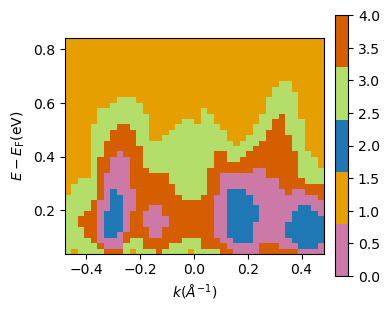

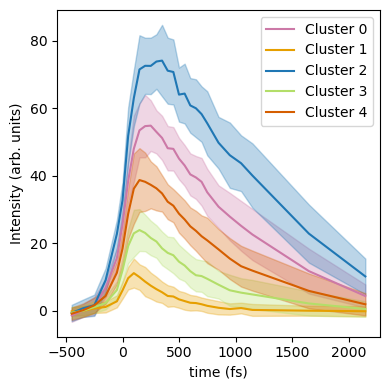

In [11]:
index_map = {0: 3, 1: 0, 2: 4, 3: 1, 4: 2}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters=5, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)


plot_clusters_raw(n_clusters=5, results=results, custom_cmap=custom_cmap)
plot_cluster_means_raw(n_clusters=5, results=results, custom_cmap=custom_cmap)



Routines to plot the **normalized** clusters and the traces. 

The code for the plotting the standard deviations is partly commented out. 


In [12]:

def plot_clusters_norm(interested_label,interested_suffix,n_clusters, results, custom_cmap):
    roi_e = roi_dict[f'roi_e{interested_suffix}']
    num_rois_e = (roi_e[1] - roi_e[0]) // roi_e[2]
    specific_results = results[f'results{interested_suffix}'][interested_label]
    roi_k = datasets[interested_label]['def_roik']
    num_rois_k = (roi_k[1] - roi_k[0]) // roi_k[2]

    # Retrieve the KMeans models
    kmeans_intensities_model = specific_results['kmeans_norm']
    cluster_labels_intensities = kmeans_intensities_model.labels_


    fig, ax = plt.subplots(figsize=(4, 8))   
    
    # Generate the cluster images using the remapped labels
    cluster_image_all = np.zeros((num_rois_k, num_rois_e))
    k = 0
    roi_y_values = np.zeros_like(cluster_labels_intensities, dtype=float)
    for roi_x in range(num_rois_k):
        for roi_y in range(num_rois_e):
            cluster_image_all[roi_x, roi_y] = cluster_labels_intensities[k]
            roi_y_values[k] = roi_y
            k += 1
            
    # Calculate average and standard deviation of roi_y for each cluster
    average_roi_y = np.zeros(n_clusters)
    std_dev_roi_y = np.zeros(n_clusters)
    average_e = np.zeros(n_clusters)
    std_dev_e = np.zeros(n_clusters)
    for i in range(n_clusters):
        indices = (cluster_labels_intensities == i)
        print(i)
        average_roi_y[i] = np.mean(roi_y_values[indices])
        average_e[i] = d27_E[roi_e[0]] + (d27_E[roi_e[1]] - d27_E[roi_e[0]]) * (0.5 + np.mean(roi_y_values[indices])) /num_rois_e
        std_dev_roi_y[i] = np.std(roi_y_values[indices])
        std_dev_e[i] = (d27_E[roi_e[1]] - d27_E[roi_e[0]]) * np.std(roi_y_values[indices]) / num_rois_e
        #print(f"Cluster {i}: Average roi_y = {average_roi_y[i]:.2f}, Std Dev = {std_dev_roi_y[i]:.2f}")
        print(f"Cluster {i}: Average energy = {average_e[i]:.2f}, Std Dev = {std_dev_e[i]:.2f}")


    # Plotting "All Intensities"
    im_all = ax.imshow(cluster_image_all.T,cmap=custom_cmap,extent=[d27_k[roi_k[0]],d27_k[roi_k[1]],d27_E[roi_e[1]],d27_E[roi_e[0]]])
    plt.colorbar(im_all, ax=ax, fraction=0.046, pad=0.04)
    # ax.set_title("Fig. 1c")
    ax.invert_yaxis()
    ax.set_xlabel(r"$\mathit{k}(\AA^{-1})$")
    ax.set_ylabel(r"$E-E_{\mathrm{F}}(\mathrm{eV)}$")
    # plt.savefig('clusters_norm.pdf', format='pdf')
    # plt.savefig('clusters_norm.svg', format='svg')
    fig.tight_layout()
    plt.show()



In [13]:

def plot_cluster_means_norm(interested_label,interested_suffix,n_clusters, results, custom_cmap,lowlimy):

    specific_results = results[f'results{interested_suffix}'][interested_label]
    kmeans_intensities_model = specific_results['kmeans_norm']
    cluster_centers_intensities = kmeans_intensities_model.cluster_centers_
    labels = kmeans_intensities_model.labels_
    intensities = results[f'results{interested_suffix}'][interested_label]['normalized_intensities']
    # Calculate the standard deviation of data points in each cluster
    cluster_stds = []
    for i in range(n_clusters):
        cluster_points = intensities[labels == i]
        # Calculate std deviation across all points in the cluster along the time axis
        cluster_std = np.std(cluster_points, axis=0)
        cluster_stds.append(cluster_std)

    # Extract colors from the colormap
    colors = [custom_cmap.colors[i] for i in range(n_clusters)]

    fig, ax = plt.subplots(figsize=(4, 4)) 
    # Plot cluster centers for intensities
    for i in range(n_clusters):
        ax.plot(time, cluster_centers_intensities[i], label=f'Cluster {i}', color=colors[i])
        # Add shaded area for variance
        # ax.fill_between(time, 
        #                 cluster_centers_intensities[i] - cluster_stds[i], 
        #                 cluster_centers_intensities[i] + cluster_stds[i], 
        #                 color=colors[i], alpha=0.3)

    # ax.set_xlabel("time (fs)")
    # ax.set_ylabel("Intensity (arb. units)")
    # ax.legend()

    # Get current maximum y-axis limit
    _, ymax = ax.get_ylim()
    # Set minimum y-axis limit
    ymax = 1.1
    ax.set_ylim(lowlimy, ymax)
    # plt.savefig('cluster_means_norm.svg', format='svg')
    # plt.savefig('cluster_means_norm.pdf', format='pdf')
    fig.tight_layout()
    plt.show()





Here the normalized traces are also plotted but before they are normalized **again** to 1 in order to facilitate the lineshape comparison.

In [14]:

def plot_cluster_means_norm_norm(interested_label, interested_suffix, n_clusters, results, custom_cmap, lowlimy):

    specific_results = results[f'results{interested_suffix}'][interested_label]
    kmeans_intensities_model = specific_results['kmeans_norm']
    cluster_centers_intensities = kmeans_intensities_model.cluster_centers_
    labels = kmeans_intensities_model.labels_
    intensities = results[f'results{interested_suffix}'][interested_label]['normalized_intensities']
    # Calculate the standard deviation of data points in each cluster
    cluster_stds = []
    for i in range(n_clusters):
        cluster_points = intensities[labels == i]
        cluster_std = np.std(cluster_points, axis=0)
        cluster_stds.append(cluster_std)

    # Initialize another array for the traces that are then normed again.
    cluster_centers_intensities_norm = np.copy(cluster_centers_intensities)
    
    # Extract colors from the colormap
    colors = [custom_cmap.colors[i] for i in range(n_clusters)]

    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Plot cluster centers for intensities
    for i in range(n_clusters):
        max_val = np.max(cluster_centers_intensities[i])
        if max_val > 0:
            normalized_cluster_mean = cluster_centers_intensities[i] / max_val
            normalized_cluster_std = cluster_stds[i] / max_val

            ax.plot(time, normalized_cluster_mean, label=f'Cluster {i}', color=colors[i])
            # ax.fill_between(time, 
            #                 normalized_cluster_mean - normalized_cluster_std, 
            #                 normalized_cluster_mean + normalized_cluster_std, 
            #                 color=colors[i], alpha=0.3)

    # ax.set_xlabel("time (fs)")
    # ax.set_ylabel("Intensity (arb. units)")
    # ax.legend()

    # Get current maximum y-axis limit
    _, ymax = ax.get_ylim()
    ymax = 1.05
    # Set minimum y-axis limit
    ax.set_ylim(lowlimy, ymax)
    # plt.savefig('cluster_means_norm_norm.svg', format='svg')
    # plt.savefig('cluster_means_norm_norm.pdf', format='pdf')
    fig.tight_layout()
    plt.show()


Plot Fig. 5(c) and the corresponding cluster centroids. 

0
Cluster 0: Average energy = 0.32, Std Dev = 0.07
1
Cluster 1: Average energy = 0.76, Std Dev = 0.06
2
Cluster 2: Average energy = 0.49, Std Dev = 0.07
3
Cluster 3: Average energy = 0.15, Std Dev = 0.07
4
Cluster 4: Average energy = 0.65, Std Dev = 0.08


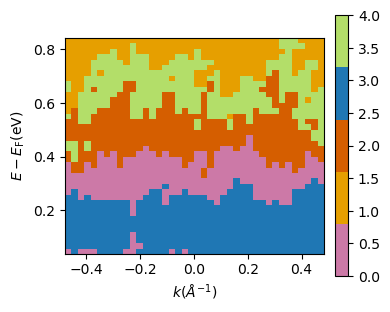

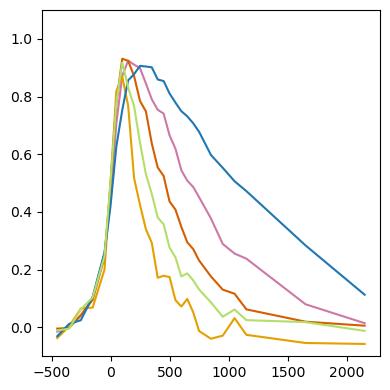

In [15]:
index_map = {0: 3, 1: 0, 2: 2, 3: 4, 4: 1}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters=5, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)

plot_clusters_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=5, results=results, custom_cmap=custom_cmap)
plot_cluster_means_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=5, results=results, custom_cmap=custom_cmap, lowlimy = -0.1)

## Figure 7

7 clusters

In [16]:
n_clusters = 7

results = {}  # This dictionary will store all results, keyed by the suffix ('20', '30', etc.)

# for suffix in ['20', '30', '150', '200', '250', '350', '450']:  # Extend this list based on the suffixes you have in roi_dict
for suffix in ['450']:  # Extend this list based on the suffixes you have in roi_dict
    # Dynamically access roi_k and roi_e values from roi_dict
    roi_e = roi_dict[f'roi_e{suffix}']
    
    current_results = {}
    
    for label, dataset_info in datasets.items():
        # Extract the file path from the dataset_info
        path = dataset_info['path']
        roi_k = dataset_info['def_roik']
        # Process each dataset
        intensities, norm_intensities = process_dataset(path, dimt, dimx, dimy, roi_k, roi_e)
        
        # K-means clustering on intensities
        kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities)

        # K-means clustering on normalized_intensities
        kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensities)

        # Store the results for this label
        current_results[label] = {
            'intensities': intensities,
            'normalized_intensities': norm_intensities,
            'kmeans_all': kmeans_intensities,
            'kmeans_norm': kmeans_norm_intensities
        }
    
    # After processing all labels for this suffix, store them in the main results dictionary
    results[f'results{suffix}'] = current_results


0
Cluster 0: Average energy = 0.16, Std Dev = 0.06
1
Cluster 1: Average energy = 0.68, Std Dev = 0.08
2
Cluster 2: Average energy = 0.39, Std Dev = 0.05
3
Cluster 3: Average energy = 0.54, Std Dev = 0.07
4
Cluster 4: Average energy = 0.29, Std Dev = 0.04
5
Cluster 5: Average energy = 0.77, Std Dev = 0.06
6
Cluster 6: Average energy = 0.10, Std Dev = 0.05


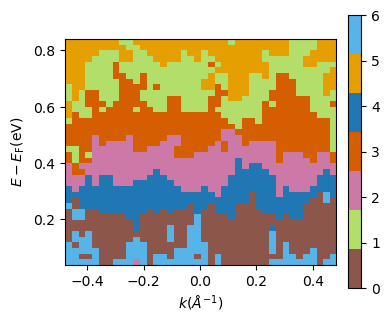

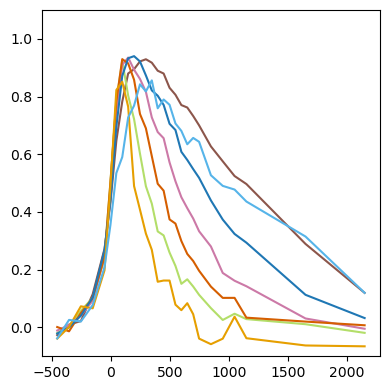

In [17]:
index_map = {0: 5, 1: 1, 2: 3, 3: 2, 4: 4, 5: 0, 6: 6}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters=7, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)


plot_clusters_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=7, results=results, custom_cmap=custom_cmap)
plot_cluster_means_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=7, results=results, custom_cmap=custom_cmap, lowlimy = -0.1)

10 clusters

In [18]:
n_clusters = 10

results = {}  # This dictionary will store all results, keyed by the suffix ('20', '30', etc.)

# for suffix in ['20', '30', '150', '200', '250', '350', '450']:  # Extend this list based on the suffixes you have in roi_dict
for suffix in ['450']:  # Extend this list based on the suffixes you have in roi_dict
    # Dynamically access roi_k and roi_e values from roi_dict
    roi_e = roi_dict[f'roi_e{suffix}']
    
    current_results = {}
    
    for label, dataset_info in datasets.items():
        # Extract the file path from the dataset_info
        path = dataset_info['path']
        roi_k = dataset_info['def_roik']
        # Process each dataset
        intensities, norm_intensities = process_dataset(path, dimt, dimx, dimy, roi_k, roi_e)
        
        # K-means clustering on intensities
        kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities)

        # K-means clustering on normalized_intensities
        kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensities)

        # Store the results for this label
        current_results[label] = {
            'intensities': intensities,
            'normalized_intensities': norm_intensities,
            'kmeans_all': kmeans_intensities,
            'kmeans_norm': kmeans_norm_intensities
        }
    
    # After processing all labels for this suffix, store them in the main results dictionary
    results[f'results{suffix}'] = current_results

0
Cluster 0: Average energy = 0.67, Std Dev = 0.08
1
Cluster 1: Average energy = 0.25, Std Dev = 0.04
2
Cluster 2: Average energy = 0.77, Std Dev = 0.06
3
Cluster 3: Average energy = 0.43, Std Dev = 0.06
4
Cluster 4: Average energy = 0.14, Std Dev = 0.05
5
Cluster 5: Average energy = 0.74, Std Dev = 0.06
6
Cluster 6: Average energy = 0.34, Std Dev = 0.04
7
Cluster 7: Average energy = 0.72, Std Dev = 0.07
8
Cluster 8: Average energy = 0.55, Std Dev = 0.07
9
Cluster 9: Average energy = 0.09, Std Dev = 0.04


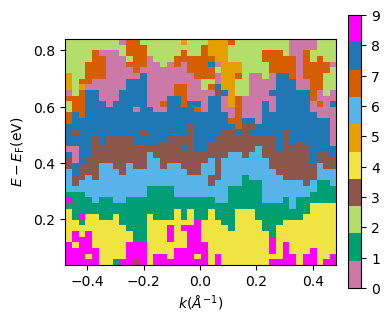

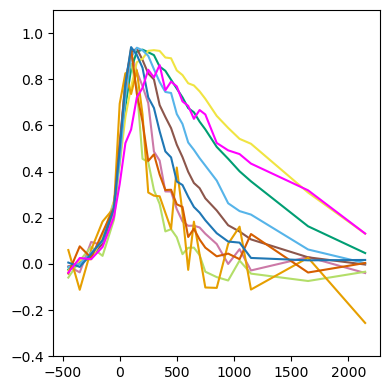

In [19]:
index_map = {0: 3, 1: 7, 2: 1, 3: 5, 4: 8, 5: 0, 6: 6, 7: 2, 8: 4, 9: 9}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters=10, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)


plot_clusters_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=10, results=results, custom_cmap=custom_cmap)
plot_cluster_means_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=10, results=results, custom_cmap=custom_cmap, lowlimy = -0.4)

5 clusters but with an intensity threshold below which the data isn't plotted (or plotted in white). 

Note that all the low intensity data is dumped into an artificial cluster. Therefore the varialbe n_clusters is 6 here = 5 clusters and the artificial cluster. 

In [20]:

n_clusters = 6 # the relevant number of clusters is n_clusters - 1 because on cluster is used for the low intensity data below the threshold 
threshold = 20  # Example threshold value, adjust as needed
# Since all data sets are now normalized to 100 max intensity (for one photon energy), this threshold is the percentage value of the maximum intensity at a given photon energy.

results = {}  # This dictionary will store all results, keyed by the suffix ('20', '30', etc.)

for suffix in ['450']:  # Extend this list based on the su
    # suffixes you have in roi_dict

# for suffix in ['450']:  # faster version for tests
    roi_e = roi_dict[f'roi_e{suffix}']
    
    current_results = {}
    
    for label, dataset_info in datasets.items():
        path = dataset_info['path']
        roi_k = dataset_info['def_roik']
        
        # Process each dataset
        intensities, norm_intensities = process_dataset(path, dimt, dimx, dimy, roi_k, roi_e)
        
        # Identify curves that exceed the threshold and set them to negative values
        valid_indices = [idx for idx, intensity in enumerate(intensities) if np.max(np.abs(intensity)) > threshold]
        exceeds_threshold = np.max(np.abs(intensities), axis=1) > threshold
        intensities[~exceeds_threshold] = -100  # Set all values in rows not exceeding the threshold
        norm_intensities[~exceeds_threshold] = -0.5
        valid_indices = np.where(exceeds_threshold)[0]    
        
        # Filter intensities and normalized_intensities for clustering
        filtered_intensities = intensities[valid_indices]
        filtered_norm_intensities = norm_intensities[valid_indices]
        
        # Perform K-means clustering if there are any valid curves
        if len(filtered_intensities) > 0:
            #kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(filtered_intensities)
            #kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(filtered_norm_intensities)
            kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities)
            kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensities)
            
            # Store the results, including which curves were clustered
            current_results[label] = {
                #'intensities': filtered_intensities,
                'intensities': intensities,
                #'normalized_intensities': filtered_norm_intensities,
                'normalized_intensities': norm_intensities,
                'kmeans_all': kmeans_intensities,
                'kmeans_norm': kmeans_norm_intensities,
                'clustered_curves_indices': valid_indices  # Track the indices of curves that were clustered
            }
        else:
            # Handle the case where no curves exceed the threshold
            print('none of the curves exceeds the threshold')
            current_results[label] = {
                'intensities': np.array([]),
                'normalized_intensities': np.array([]),
                'kmeans_all': None,
                'kmeans_norm': None,
                'clustered_curves_indices': []  # No curves were clustered
            }
    
    # After processing all labels for this suffix, store them in the main results dictionary
    results[f'results{suffix}'] = current_results


Now the plot with the threshold.


0
Cluster 0: Average energy = 0.54, Std Dev = 0.07
1
Cluster 1: Average energy = 0.65, Std Dev = 0.15
2
Cluster 2: Average energy = 0.15, Std Dev = 0.05
3
Cluster 3: Average energy = 0.39, Std Dev = 0.05
4
Cluster 4: Average energy = 0.10, Std Dev = 0.05
5
Cluster 5: Average energy = 0.28, Std Dev = 0.05


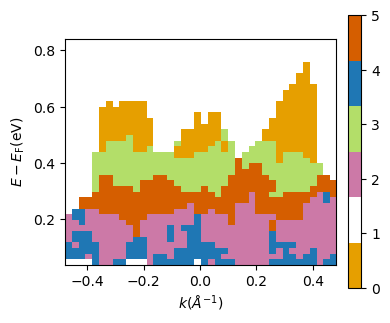

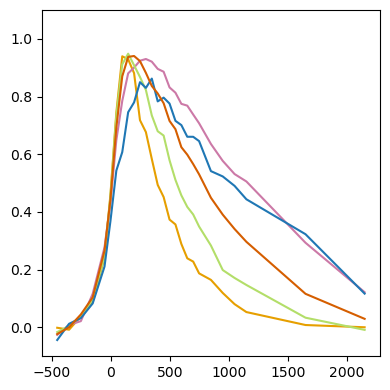

In [21]:

index_map = {0: 0, 1: 11, 2: 3, 3: 1, 4: 4, 5: 2}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters=6, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)

plot_clusters_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=6, results=results, custom_cmap=custom_cmap)
plot_cluster_means_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=6, results=results, custom_cmap=custom_cmap, lowlimy = -0.1)


## Figure 8

We use 5 clusters but for all photon energies together. We also give the mean energy for each cluster in order to then construct Figure 4(d).

In [22]:

n_clusters = 6 # the relevant number of clusters is n_clusters - 1 because on cluster is used for the low intensity data below the threshold 
threshold = 20  # Example threshold value, adjust as needed
# Since all data sets are now normalized to 100 max intensity (for one photon energy), this threshold is the percentage value of the maximum intensity at a given photon energy.

results = {}  # This dictionary will store all results, keyed by the suffix ('20', '30', etc.)

for suffix in ['450']:  # Extend this list based on the suffixes you have in roi_dict

# for suffix in ['450']:  # faster version for tests
    roi_e = roi_dict[f'roi_e{suffix}']
    
    current_results = {}
    
    for label, dataset_info in datasets.items():
        path = dataset_info['path']
        roi_k = dataset_info['def_roik']
        
        # Process each dataset
        intensities, norm_intensities = process_dataset(path, dimt, dimx, dimy, roi_k, roi_e)
        
        # Identify curves that exceed the threshold and set them to negative values
        valid_indices = [idx for idx, intensity in enumerate(intensities) if np.max(np.abs(intensity)) > threshold]
        exceeds_threshold = np.max(np.abs(intensities), axis=1) > threshold
        intensities[~exceeds_threshold] = -100  # Set all values in rows not exceeding the threshold
        norm_intensities[~exceeds_threshold] = -0.5
        valid_indices = np.where(exceeds_threshold)[0]    
        
        # Filter intensities and normalized_intensities for clustering
        filtered_intensities = intensities[valid_indices]
        filtered_norm_intensities = norm_intensities[valid_indices]
        
        # Perform K-means clustering if there are any valid curves
        if len(filtered_intensities) > 0:
            #kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(filtered_intensities)
            #kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(filtered_norm_intensities)
            kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities)
            kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensities)
            
            # Store the results, including which curves were clustered
            current_results[label] = {
                #'intensities': filtered_intensities,
                'intensities': intensities,
                #'normalized_intensities': filtered_norm_intensities,
                'normalized_intensities': norm_intensities,
                'kmeans_all': kmeans_intensities,
                'kmeans_norm': kmeans_norm_intensities,
                'clustered_curves_indices': valid_indices  # Track the indices of curves that were clustered
            }
        else:
            # Handle the case where no curves exceed the threshold
            print('none of the curves exceeds the threshold')
            current_results[label] = {
                'intensities': np.array([]),
                'normalized_intensities': np.array([]),
                'kmeans_all': None,
                'kmeans_norm': None,
                'clustered_curves_indices': []  # No curves were clustered
            }
    
    # After processing all labels for this suffix, store them in the main results dictionary
    results[f'results{suffix}'] = current_results


0
Cluster 0: Average energy = 0.67, Std Dev = 0.10
1
Cluster 1: Average energy = 0.23, Std Dev = 0.07
2
Cluster 2: Average energy = 0.35, Std Dev = 0.06
3
Cluster 3: Average energy = 0.42, Std Dev = 0.07
4
Cluster 4: Average energy = 0.13, Std Dev = 0.05
5
Cluster 5: Average energy = 0.52, Std Dev = 0.08


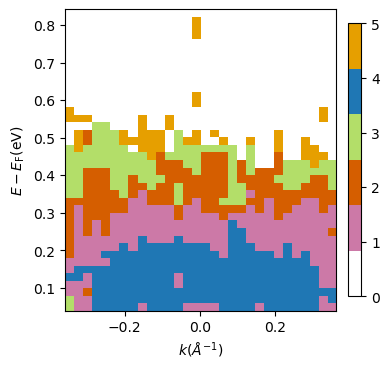

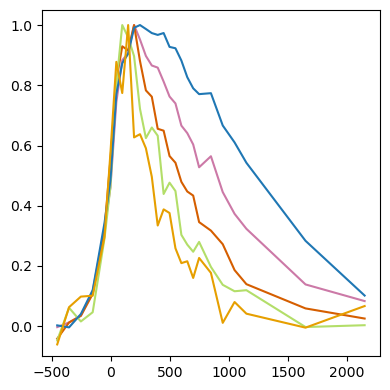

0
Cluster 0: Average energy = 0.54, Std Dev = 0.07
1
Cluster 1: Average energy = 0.65, Std Dev = 0.15
2
Cluster 2: Average energy = 0.15, Std Dev = 0.05
3
Cluster 3: Average energy = 0.39, Std Dev = 0.05
4
Cluster 4: Average energy = 0.10, Std Dev = 0.05
5
Cluster 5: Average energy = 0.28, Std Dev = 0.05


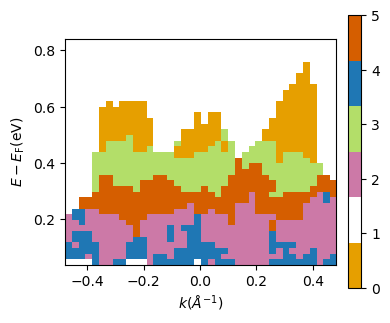

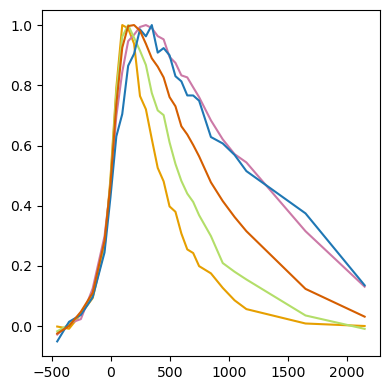

0
Cluster 0: Average energy = 0.37, Std Dev = 0.06
1
Cluster 1: Average energy = 0.63, Std Dev = 0.17
2
Cluster 2: Average energy = 0.23, Std Dev = 0.07
3
Cluster 3: Average energy = 0.53, Std Dev = 0.10
4
Cluster 4: Average energy = 0.15, Std Dev = 0.05
5
Cluster 5: Average energy = 0.10, Std Dev = 0.05


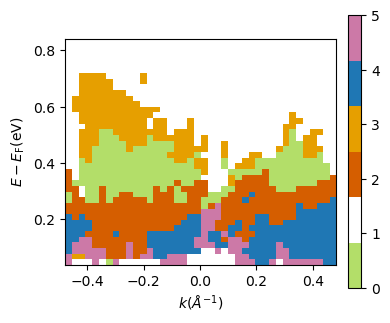

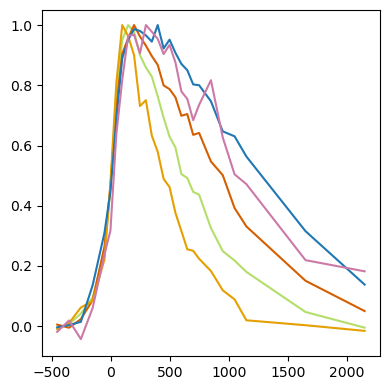

In [23]:


index_map = {0: 11, 1: 3, 2: 2, 3: 1, 4: 4, 5: 0}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)

plot_clusters_norm(interested_label = 'd21',interested_suffix = '450', n_clusters=n_clusters, results=results, custom_cmap=custom_cmap)
plot_cluster_means_norm_norm(interested_label = 'd21',interested_suffix = '450', n_clusters=n_clusters, results=results, custom_cmap=custom_cmap, lowlimy = -0.1)

# index_map = {0: 0, 1: 11, 2: 4, 3: 1, 4: 3, 5: 2} 
index_map = {0: 0, 1: 11, 2: 3, 3: 1, 4: 4, 5: 2}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)

plot_clusters_norm(interested_label = 'd27',interested_suffix = '450',n_clusters=n_clusters, results=results, custom_cmap=custom_cmap)
plot_cluster_means_norm_norm(interested_label = 'd27',interested_suffix = '450', n_clusters=n_clusters, results=results, custom_cmap=custom_cmap, lowlimy = -0.1)

index_map = {0: 1, 1: 11, 2: 2, 3: 0, 4: 4, 5: 3}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters=n_clusters, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)

plot_clusters_norm(interested_label = 'd33',interested_suffix = '450', n_clusters=n_clusters, results=results, custom_cmap=custom_cmap)
plot_cluster_means_norm_norm(interested_label = 'd33',interested_suffix = '450', n_clusters=n_clusters, results=results, custom_cmap=custom_cmap, lowlimy = -0.1)

## Fig 10

### Concatenated traces

The clustering is carried out on the concatenated the traces at 27.4 eV and 33.2 eV and to cluster the result. This makes most sense for the normalized traces but I calculate it for both. 

Note that the sorting of the curves with respect to a threshold is still implemented here. So in the concatenated traces, some will have the first part below zero and some will have the second part below zero.

In [24]:
n_clusters = 7 # the relevant number of clusters is n_clusters - 1 because on cluster is used for the low intensity data below the threshold 
threshold = 20  # Example threshold value, adjust as needed
# Since all data sets are now normalized to 100 max intensity (for one photon energy), this threshold is the percentage value of the maximum intensity at a given photon energy.

results = {}  # This dictionary will store all results, keyed by the suffix ('20', '30', etc.)

for suffix in ['450']:  # Extend this list based on the suffixes you have in roi_dict

# for suffix in ['450']:  # faster version for tests
    roi_e = roi_dict[f'roi_e{suffix}']
    
    current_results = {}
    
    for label, dataset_info in datasets.items():
        path = dataset_info['path']
        roi_k = dataset_info['def_roik']
        
        # Process each dataset
        intensities, norm_intensities = process_dataset(path, dimt, dimx, dimy, roi_k, roi_e)
        
        # Identify curves that exceed the threshold and set them to negative values
        valid_indices = [idx for idx, intensity in enumerate(intensities) if np.max(np.abs(intensity)) > threshold]
        exceeds_threshold = np.max(np.abs(intensities), axis=1) > threshold
        intensities[~exceeds_threshold] = -100  # Set all values in rows not exceeding the threshold
        norm_intensities[~exceeds_threshold] = -0.5
        valid_indices = np.where(exceeds_threshold)[0]    
        
        # Filter intensities and normalized_intensities for clustering
        filtered_intensities = intensities[valid_indices]
        filtered_norm_intensities = norm_intensities[valid_indices]
        
        # Perform K-means clustering if there are any valid curves
        if len(filtered_intensities) > 0:
            #kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(filtered_intensities)
            #kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(filtered_norm_intensities)
            kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities)
            kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensities)
            
            # Store the results, including which curves were clustered
            current_results[label] = {
                #'intensities': filtered_intensities,
                'intensities': intensities,
                #'normalized_intensities': filtered_norm_intensities,
                'normalized_intensities': norm_intensities,
                'kmeans_all': kmeans_intensities,
                'kmeans_norm': kmeans_norm_intensities,
                'clustered_curves_indices': valid_indices  # Track the indices of curves that were clustered
            }
        else:
            # Handle the case where no curves exceed the threshold
            print('none of the curves exceeds the threshold')
            current_results[label] = {
                'intensities': np.array([]),
                'normalized_intensities': np.array([]),
                'kmeans_all': None,
                'kmeans_norm': None,
                'clustered_curves_indices': []  # No curves were clustered
            }
    
    # After processing all labels for this suffix, store them in the main results dictionary
    results[f'results{suffix}'] = current_results



In [25]:
# Extracting the relevant data for d27 and d33
d27_intensities = results['results450']['d27']['intensities']
d27_norm_intensities = results['results450']['d27']['normalized_intensities']
d33_intensities = results['results450']['d33']['intensities']
d33_norm_intensities = results['results450']['d33']['normalized_intensities']

# Concatenating the all_integrated_intensities for d27 and d33
concatenated_intensities = np.concatenate((d27_intensities, d33_intensities), axis=1)

# Concatenating the normalized_intensities for d27 and d33
concatenated_norm_intensities = np.concatenate((d27_norm_intensities, d33_norm_intensities), axis=1)

# K-means clustering on intensities
kmeans_conc_int = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(concatenated_intensities)

# K-means clustering on normalized_intensities
kmeans_conc_norm_int = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(concatenated_norm_intensities)

In [26]:


# Define the specific label and suffix you're interested in
label1 = 'd27'  # label of first data set
label2 = 'd33'  # label of second data set
interested_suffix = '450'  # Example suffix

# Access the clustered indices for the interested label and suffix
clustered_indices1 = results[f'results{interested_suffix}'][label1]['clustered_curves_indices']
clustered_indices2 = results[f'results{interested_suffix}'][label2]['clustered_curves_indices']

common_indices = np.intersect1d(clustered_indices1, clustered_indices2)


# Create a full index array for the concatenated arrays
all_indices = np.arange(concatenated_intensities.shape[0])

# Find the indices NOT in the common indices
non_common_indices = np.setdiff1d(all_indices, common_indices)

# Set the values for non-common indices in concatenated_intensities and concatenated_norm_intensities
concatenated_intensities[non_common_indices] = -100
concatenated_norm_intensities[non_common_indices] = -0.5

# Now, concatenated_intensities and concatenated_norm_intensities have -100 and -0.5 respectively
# for those indices that were not part of common_indices

# K-means clustering on intensities
kmeans_conc_int = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(concatenated_intensities)

# K-means clustering on normalized_intensities
kmeans_conc_norm_int = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(concatenated_norm_intensities)



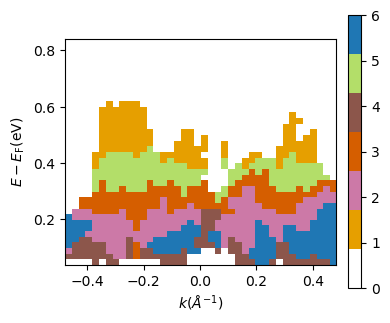

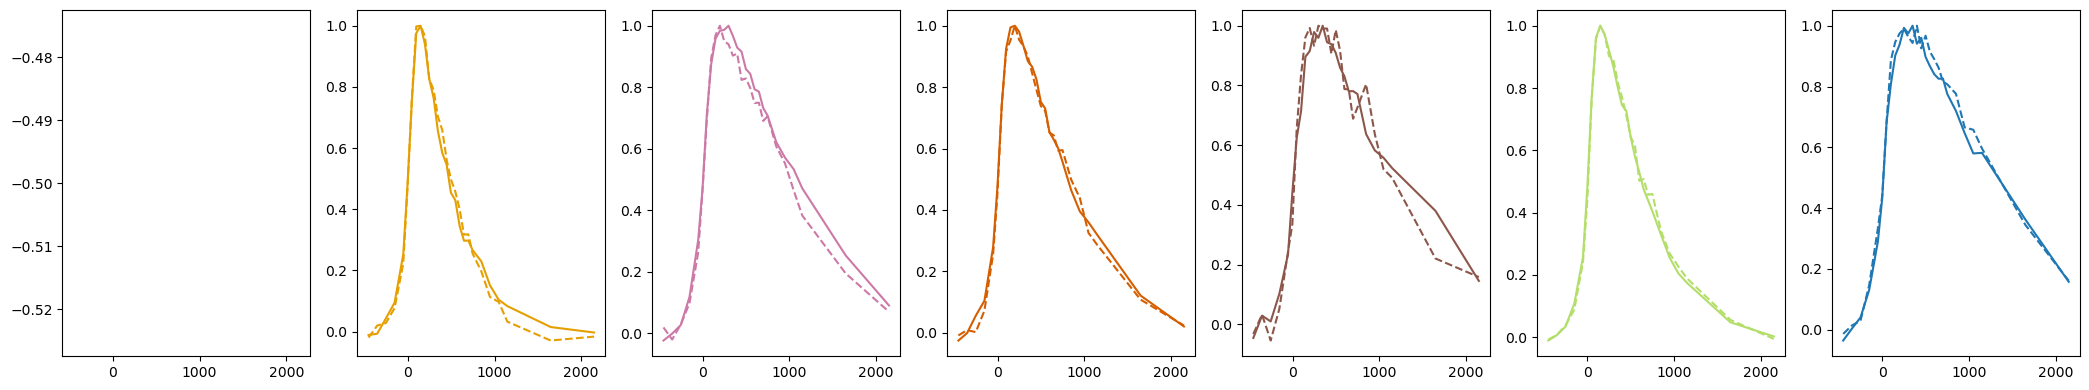

In [27]:
fig, ax = plt.subplots(figsize=(4, 8))  

# colors = plt.cm.prism(np.linspace(0, 1, 5))  
# custom_cmap = ListedColormap(colors)

# custom_colors_for_clusters = color_blind_friendly_colors[:n_clusters]
# custom_cmap = ListedColormap(custom_colors_for_clusters)

#for 7 clusters
#index_map = {0: 5, 1: 11, 2: 2, 3: 3, 4: 4, 5: 1, 6: 0}  # Define this based on your desired visual arrangement
# for 10 clusters
index_map = {0: 11, 1: 0, 2: 3, 3: 2, 4: 5, 5: 1, 6: 4}  # Define this based on your desired visual arrangement
custom_cmap = create_custom_cmap(n_clusters=n_clusters, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)


roi_e = roi_dict[f'roi_e{suffix}']
num_rois_per_e = (roi_e[1] - roi_e[0]) // roi_e[2]
num_rois_per_k = (roi_k[1] - roi_k[0]) // roi_k[2]
n = roi_k[2]
m = roi_e[2]

# Plot for kmeans_intensities
cluster_ass_conc_int = kmeans_conc_int.labels_
cluster_im_conc_int = np.zeros((num_rois_per_k, num_rois_per_e))

cluster_ass_conc_norm = kmeans_conc_norm_int.labels_
cluster_im_conc_norm = np.zeros((num_rois_per_k, num_rois_per_e))

k = 0
for roi_x in range(num_rois_per_k):
    for roi_y in range(num_rois_per_e):
        cluster_im_conc_norm[roi_x, roi_y] = cluster_ass_conc_norm[k]
        k += 1

im_norm = ax.imshow(cluster_im_conc_norm.T, cmap=custom_cmap,extent=[d27_k[roi_k[0]],d27_k[roi_k[1]],d27_E[roi_e[1]],d27_E[roi_e[0]]])
plt.colorbar(im_norm, ax=ax, fraction=0.046, pad=0.04)
    # ax.set_title("Fig. 1c")
ax.invert_yaxis()
ax.set_xlabel(r"$\mathit{k}(\AA^{-1})$")
ax.set_ylabel(r"$E-E_{\mathrm{F}}(\mathrm{eV)}$")
# plt.savefig('fig_5_map.svg', format='svg')
# plt.savefig('fig_4_map.pdf', format='pdf')
fig.tight_layout()
plt.show()


dimt2 = 2 * dimt # the concatenated time traces are twice as long 

time2 = np.concatenate((time, time), axis=0) # We could add an artificial delay to the second trace, but if we don't, then we can compare them directly
import numpy as np
import matplotlib.pyplot as plt

# Example setup for variables that must be defined
# n_clusters, dimt2, concatenated_norm_intensities, kmeans_conc_norm_int, time, and axes

colors = [custom_cmap.colors[i] for i in range(n_clusters)]
cluster_assignments = kmeans_conc_norm_int.labels_

# Prepare a figure with subplots
# larger version 
#fig, axes = plt.subplots(n_clusters, 1, figsize=(7, 5 * n_clusters))  # Adjust subplot size as needed

# original smaller version
fig, axes = plt.subplots(1, n_clusters, figsize=(n_clusters * 3, 4))


for j in range(n_clusters):
    cluster_data = concatenated_norm_intensities[cluster_assignments == j]
    numcluster = cluster_data.shape[0]

    if numcluster > 0:
        cluster_mean_trace = np.mean(cluster_data, axis=0)
        cluster_std_trace = np.std(cluster_data, axis=0)

        # Split the array into two halves for both mean and std
        midpoint = len(cluster_mean_trace) // 2
        cluster_mean_trace1 = cluster_mean_trace[:midpoint]
        cluster_mean_trace2 = cluster_mean_trace[midpoint:]
        cluster_std_trace1 = cluster_std_trace[:midpoint]
        cluster_std_trace2 = cluster_std_trace[midpoint:]

        # Normalize each half so that the maximum value is 1
        if np.max(cluster_mean_trace1) > 0:
            cluster_mean_trace1 = cluster_mean_trace1 / np.max(cluster_mean_trace1)
            cluster_std_trace1 = cluster_std_trace1 / np.max(cluster_mean_trace1)
        if np.max(cluster_mean_trace2) > 0:
            cluster_mean_trace2 = cluster_mean_trace2 / np.max(cluster_mean_trace2)
            cluster_std_trace2 = cluster_std_trace2 / np.max(cluster_mean_trace2)

        # Plot the normalized traces with shaded areas
        axes[j].plot(time, cluster_mean_trace1, label=f'Cluster {j} Part 1', color=colors[j])
        #axes[j].fill_between(time, cluster_mean_trace1 - cluster_std_trace1, cluster_mean_trace1 + cluster_std_trace1, color=colors[j], alpha=0.3)
        axes[j].plot(time, cluster_mean_trace2, label=f'Cluster {j} Part 2', color=colors[j], linestyle='--')
        #axes[j].fill_between(time, cluster_mean_trace2 - cluster_std_trace2, cluster_mean_trace2 + cluster_std_trace2, color=colors[j], alpha=0.3)

        #axes[j].set_title(f"Normalized Intensities - Cluster {j}")
        #axes[j].set_xlabel("Time (fs)")
        #axes[j].set_ylabel("Intensity (arb. units)")
# plt.savefig('fig_9_clusters.svg', format='svg')
# plt.savefig('fig_9_clusters.pdf', format='pdf')
plt.tight_layout()
plt.show()
